Training classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]
Remaining classes: [90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
Files already downloaded and verified
Files already downloaded and verified
No checkpoint found at '../checkpoints/checkpoint.pt'
Same Class Pairs:


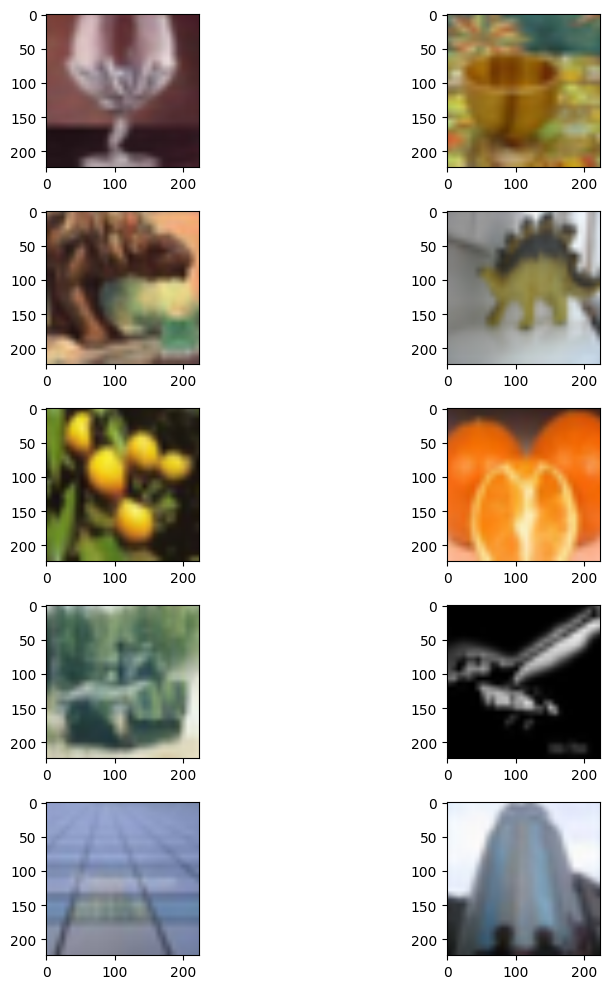

Different Class Pairs:


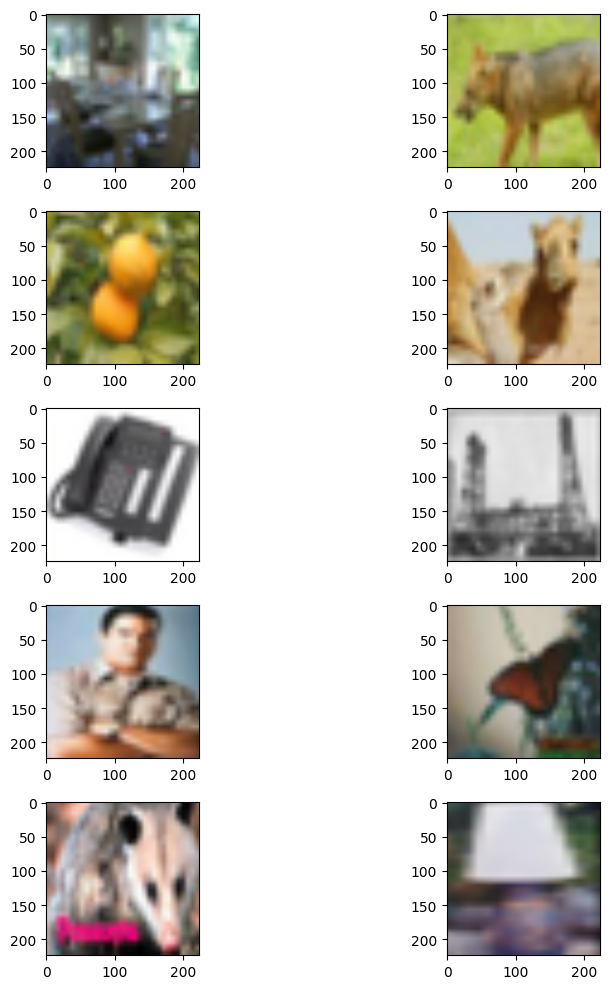

Train Epoch: 1 [0/45000 (0%)]	Loss: 0.704218
Train Epoch: 1 [320/45000 (1%)]	Loss: 0.690929
Train Epoch: 1 [640/45000 (1%)]	Loss: 0.708176
Train Epoch: 1 [960/45000 (2%)]	Loss: 0.603586
Train Epoch: 1 [1280/45000 (3%)]	Loss: 0.687264
Train Epoch: 1 [1600/45000 (4%)]	Loss: 0.696262
Train Epoch: 1 [1920/45000 (4%)]	Loss: 0.688040
Train Epoch: 1 [2240/45000 (5%)]	Loss: 0.701457
Train Epoch: 1 [2560/45000 (6%)]	Loss: 0.628247
Train Epoch: 1 [2880/45000 (6%)]	Loss: 0.678457
Train Epoch: 1 [3200/45000 (7%)]	Loss: 0.687739
Checkpoint saved at epoch 1, batch 100
Train Epoch: 1 [3520/45000 (8%)]	Loss: 0.679014
Train Epoch: 1 [3840/45000 (9%)]	Loss: 0.704565
Train Epoch: 1 [4160/45000 (9%)]	Loss: 0.691459
Train Epoch: 1 [4480/45000 (10%)]	Loss: 0.699315
Train Epoch: 1 [4800/45000 (11%)]	Loss: 0.701109
Train Epoch: 1 [5120/45000 (11%)]	Loss: 0.618052
Train Epoch: 1 [5440/45000 (12%)]	Loss: 0.619956
Train Epoch: 1 [5760/45000 (13%)]	Loss: 0.644694
Train Epoch: 1 [6080/45000 (14%)]	Loss: 0.662365
T

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import numpy as np
import random
import torch.optim as optim
import torch.nn as nn
import torchvision.models as models
from PIL import Image
import os

# Check if CUDA is available and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the loss function
loss_fn = nn.BCELoss()

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images for ResNet
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762))
])

args = {
    'batch_size': 32,
    'test_batch_size': 32,
    'epochs': 10,
    'lr': 0.001,
    'same_class_ratio': 0.6,
    'no_cuda': False,
    'no_mps': False,
    'dry_run': False,
    'seed': 1,
    'log_interval': 10,
    'save_model': True,
    'save_interval_batches': 100,
    'seed': 42,
    'checkpoint_path': '../checkpoints/checkpoint.pt'
}

# Set random seed for reproducibility
torch.manual_seed(args['seed'])

import random
import torch
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
from torchvision import datasets

class SiameseCIFAR100(Dataset):
    def __init__(self, root, train=True, download=False, transform=None, classes_to_include=None, same_class_ratio=0.5):
        super(SiameseCIFAR100, self).__init__()

        # Get CIFAR-100 dataset
        self.dataset = datasets.CIFAR100(root, train=train, download=download)
        
        self.transform = transform
        self.train = train
        self.classes_to_include = classes_to_include if classes_to_include else list(range(100))
        self.same_class_ratio = same_class_ratio

        # Filter dataset for the selected classes
        self.data, self.targets = self.filter_dataset_by_classes()

        if self.train:
            self.group_examples()
        else:
            self.create_support_and_query_sets()

    def filter_dataset_by_classes(self):
        data = []
        targets = []
        for idx, target in enumerate(self.dataset.targets):
            if target in self.classes_to_include:
                data.append(self.dataset.data[idx])
                targets.append(target)
        return np.array(data), np.array(targets)
    
    def group_examples(self):
        np_arr = np.array(self.targets)
        self.grouped_examples = {i: np.where(np_arr == i)[0] for i in self.classes_to_include}
    
    def create_support_and_query_sets(self):
        self.support_set = {}
        self.query_set = []

        for class_id in self.classes_to_include:
            class_indices = np.where(self.targets == class_id)[0]
            support_index = random.choice(class_indices)
            self.support_set[class_id] = self.data[support_index]

            # Exclude the support sample from query set
            remaining_indices = class_indices[class_indices != support_index]
            for idx in remaining_indices:
                self.query_set.append((self.data[idx], class_id))
        
    def __len__(self):
        if self.train:
            return len(self.targets)
        else:
            return len(self.query_set)

    def __getitem__(self, index):
        if self.train:
            if random.random() < self.same_class_ratio:
                # Create a pair of images from the same class
                selected_class = random.choice(self.classes_to_include)
                random_index_1 = random.choice(self.grouped_examples[selected_class])
                index_1 = random_index_1
                image_1 = self.data[index_1]

                random_index_2 = random.choice(self.grouped_examples[selected_class])
                while random_index_2 == random_index_1:
                    random_index_2 = random.choice(self.grouped_examples[selected_class])
                index_2 = random_index_2
                image_2 = self.data[index_2]
                target = torch.tensor(1, dtype=torch.float)
            else:
                # Create a pair of images from different classes
                selected_class = random.choice(self.classes_to_include)
                random_index_1 = random.choice(self.grouped_examples[selected_class])
                index_1 = random_index_1
                image_1 = self.data[index_1]

                other_selected_class = random.choice(self.classes_to_include)
                while other_selected_class == selected_class:
                    other_selected_class = random.choice(self.classes_to_include)
                random_index_2 = random.choice(self.grouped_examples[other_selected_class])
                index_2 = random_index_2
                image_2 = self.data[index_2]
                target = torch.tensor(0, dtype=torch.float)

            image_1 = Image.fromarray(image_1)  # Convert to PIL Image
            image_2 = Image.fromarray(image_2)  # Convert to PIL Image

            if self.transform:
                image_1 = self.transform(image_1)
                image_2 = self.transform(image_2)

            return image_1, image_2, target
        else:
            query_image, query_class = self.query_set[index]
            query_image = Image.fromarray(query_image)  # Convert to PIL Image
            support_image = Image.fromarray(self.support_set[query_class])  # Convert to PIL Image

            if self.transform:
                query_image = self.transform(query_image)
                support_image = self.transform(support_image)

            return query_image, support_image, torch.tensor(query_class, dtype=torch.long)


class SiameseResNet(nn.Module):
    def __init__(self):
        super(SiameseResNet, self).__init__()
        # Load pre-trained ResNet18
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        
        # Remove the original fully connected layer and add a new one
        self.resnet.fc = nn.Identity()  # Remove the original fc layer
        
        # Define a new fully connected layer for the Siamese network
        self.fc = nn.Sequential(
            nn.Linear(512 * 2, 256),  # 512 features for each image, and 2 images
            nn.ReLU(inplace=True),
            nn.Linear(256, 1),
        )

    def forward_once(self, x):
        return self.resnet(x)

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        output = self.fc(torch.cat((output1, output2), dim=1))
        output = torch.sigmoid(output)
        return output

    
# Function definitions for training, testing, saving, loading checkpoints and creating support and query sets
def train(model, device, train_loader, optimizer, epoch, start_batch_idx=0):
    model.train()
    train_loss = 0
    for batch_idx, (data1, data2, target) in enumerate(train_loader, start=start_batch_idx):
        # Assicurati che l'indice del batch non superi la dimensione del dataset
        if batch_idx >= len(train_loader):
            break
        
        data1, data2, target = data1.to(device), data2.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data1, data2)

        target = target.unsqueeze(1)  # Ensuring the target has the correct shape

        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        if batch_idx % args['log_interval'] == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data1)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
        
        if args['save_model'] and batch_idx % args['save_interval_batches'] == 0 and batch_idx != start_batch_idx:
            save_checkpoint(model, optimizer, epoch, batch_idx, loss.item(), args['checkpoint_path'])
    
    avg_train_loss = train_loss / len(train_loader)
    return avg_train_loss



def test_optimized(model, device, test_dataset, batch_size=32):
    model.eval()
    correct = 0
    test_loss = 0
    num_pairs = 0  # Per tenere traccia del numero totale di coppie
    
    # Estrarre il support set e il query set
    support_set = test_dataset.support_set
    query_set = test_dataset.query_set
    
    # Forward pass per il support set
    support_features = {}
    with torch.no_grad():
        for support_class, support_img in support_set.items():
            support_img = Image.fromarray(support_img)  # Convertire in immagine PIL
            support_img = transform(support_img).unsqueeze(0).to(device)  # Trasformazioni e aggiunta dimensione batch
            support_features[support_class] = model.forward_once(support_img)
    
    query_images = []
    true_classes = []
    
    # Preparare batch di query images
    for query_img, true_class in query_set:
        query_img = Image.fromarray(query_img)  # Convertire in immagine PIL
        query_img = transform(query_img).to(device)  # Applicare trasformazioni
        query_images.append(query_img)
        true_classes.append(true_class)
    
    query_images = torch.stack(query_images)  # Stack di query images in batch
    true_classes = torch.tensor(true_classes, device=device)  # Convertire in tensore

    with torch.no_grad():
        # Elaborare query images in batch
        for i in range(0, len(query_images), batch_size):
            batch_query_images = query_images[i:i + batch_size]
            batch_true_classes = true_classes[i:i + batch_size]
            
            batch_query_features = model.forward_once(batch_query_images)

            # Inizializzare un array per accumulare tutte le somiglianze
            batch_similarities = torch.zeros((batch_query_features.size(0), len(support_features)), device=device)

            # Calcolare somiglianze con ogni immagine nel support set
            for j, (support_class, support_feature) in enumerate(support_features.items()):
                support_feature_expanded = support_feature.expand(batch_query_features.size(0), -1)
                output = model.fc(torch.cat((batch_query_features, support_feature_expanded), dim=1))
                output = torch.sigmoid(output)
                
                # Salvare le somiglianze
                batch_similarities[:, j] = output.squeeze()

                # Calcolo della loss
                targets = torch.tensor([1.0 if batch_true_classes[k] == support_class else 0.0 for k in range(batch_query_features.size(0))], device=device)
                loss = loss_fn(output.squeeze(), targets)
                test_loss += loss.item()
                num_pairs += batch_query_features.size(0)

            # Determinare le classi predette basate sulle somiglianze massime
            predicted_classes = batch_similarities.argmax(dim=1)
            correct += (predicted_classes == batch_true_classes).sum().item()

            # Debugging prints
            print(f'Batch {i // batch_size + 1} / {len(query_images) // batch_size + 1}')
            print(f'Batch Predicted Classes: {predicted_classes.tolist()}')
            print(f'Batch True Classes: {batch_true_classes.tolist()}')
            print(f'Batch Similarities: {batch_similarities}')

    accuracy = correct / len(query_set)
    avg_test_loss = test_loss / num_pairs  # Media su tutte le coppie
    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Test Loss: {avg_test_loss:.6f}')
    
    return accuracy, avg_test_loss



def save_checkpoint(model, optimizer, epoch, batch_idx, loss, filepath):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'batch_idx': batch_idx,
        'loss': loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved at epoch {epoch}, batch {batch_idx}")

def load_checkpoint(model, optimizer, filepath):
    if os.path.isfile(filepath):
        print(f"Loading checkpoint '{filepath}'")
        checkpoint = torch.load(filepath)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        batch_idx = checkpoint['batch_idx']
        loss = checkpoint['loss']
        print(f"Loaded checkpoint at epoch {epoch}, batch {batch_idx} with loss {loss:.6f}")
        return epoch, batch_idx
    else:
        print(f"No checkpoint found at '{filepath}'")
        return None, None

def denormalize(tensor, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    tensor = tensor * std + mean
    return torch.clamp(tensor, 0, 1)

def display_image_pairs(dataset, num_pairs=5):
    """Display pairs of images, both from the same class and different classes."""
    same_class_pairs = []
    diff_class_pairs = []   
    for i in range(len(dataset)):
        img1, img2, label = dataset[i]  # unpacking three values
        if label == 1 and len(same_class_pairs) < num_pairs:
            same_class_pairs.append((img1, img2))
        elif label == 0 and len(diff_class_pairs) < num_pairs:
            diff_class_pairs.append((img1, img2))
        
        if len(same_class_pairs) >= num_pairs and len(diff_class_pairs) >= num_pairs:
            break

    # Plot same-class pairs
    print("Same Class Pairs:")
    plt.figure(figsize=(10, 2 * num_pairs))
    for i, (img1, img2) in enumerate(same_class_pairs):
        img1 = denormalize(img1, (0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762))
        img2 = denormalize(img2, (0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762))
        plt.subplot(num_pairs, 2, 2 * i + 1)
        plt.imshow(img1.permute(1, 2, 0).numpy())
        plt.subplot(num_pairs, 2, 2 * i + 2)
        plt.imshow(img2.permute(1, 2, 0).numpy())
    plt.tight_layout()
    plt.show()

    # Plot different-class pairs
    print("Different Class Pairs:")
    plt.figure(figsize=(10, 2 * num_pairs))
    for i, (img1, img2) in enumerate(diff_class_pairs):
        img1 = denormalize(img1, (0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762))
        img2 = denormalize(img2, (0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762))
        plt.subplot(num_pairs, 2, 2 * i + 1)
        plt.imshow(img1.permute(1, 2, 0).numpy())
        plt.subplot(num_pairs, 2, 2 * i + 2)
        plt.imshow(img2.permute(1, 2, 0).numpy())
    plt.tight_layout()
    plt.show()

# Load custom Siamese CIFAR-100 dataset
# Subset of classes for training
train_classes = list(range(90))
remaining_classes = list(range(90, 100))
print(f"Training classes: {train_classes}")
print(f"Remaining classes: {remaining_classes}")

# Initialize lists to store training and testing results
train_losses = []
test_accuracies = []
test_losses = []

# Load datasets with specified classes
train_dataset = SiameseCIFAR100(root='./data', train=True, download=True, transform=transform, classes_to_include=train_classes, same_class_ratio=args['same_class_ratio'])
train_loader = DataLoader(train_dataset, batch_size=args['batch_size'], shuffle=True)
test_dataset = SiameseCIFAR100(root='./data', train=False, download=True, transform=transform, classes_to_include=remaining_classes)

# Initialize the model, optimizer, and start the training process
model = SiameseResNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=args['lr'])

# Load checkpoint if available
start_epoch, start_batch_idx = load_checkpoint(model, optimizer, args['checkpoint_path'])
if start_epoch is None:
    start_epoch = 1
    start_batch_idx = 0

# Display a few pairs of images to see what the data looks like
display_image_pairs(train_dataset, num_pairs=5)
# Training and testing loop
for epoch in range(start_epoch, args['epochs'] + 1):
    train_loss = train(model, device, train_loader, optimizer, epoch, start_batch_idx)
    train_losses.append(train_loss)
    start_batch_idx = 0  # reset batch index after the first epoch
    
    # Test the model
    test_accuracy, test_loss = test_optimized(model, device, test_dataset, args['test_batch_size'])
    test_accuracies.append(test_accuracy)
    test_losses.append(test_loss)

# Plot training loss and testing accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, args['epochs'] + 1), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, args['epochs'] + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, args['epochs'] + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Save the model if needed
if args['save_model']:
    torch.save(model.state_dict(), "./siamese_network.pt")
